# Method 7 - Best Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data.groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

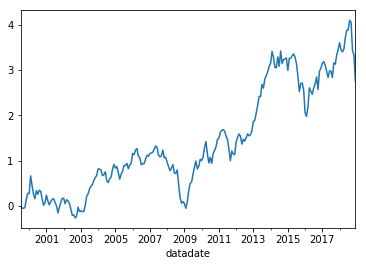

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.278581
2000-12-31   -0.164780
2001-12-31    0.092652
2002-12-31   -0.248219
2003-12-31    0.909358
2004-12-31    0.145363
2005-12-31    0.013501
2006-12-31    0.077757
2007-12-31   -0.010358
2008-12-31   -0.471356
2009-12-31    0.848758
2010-12-31    0.216870
2011-12-31   -0.136487
2012-12-31    0.249312
2013-12-31    0.535078
2014-12-31    0.044802
2015-12-31   -0.165657
2016-12-31    0.133323
2017-12-31    0.103243
2018-12-31   -0.157954
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     475.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.38e-109
Time:                        22:26:46   Log-Likelihood:                 535.60
No. Observations:                 234   AIC:                            -1061.
Df Residuals:                     229   BIC:                            -1044.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.574      0.011       0.001       0.008
mktrf          0.9219      0.046     19.934      0.000       0.831       1.013
me             0.8031      0.054     14.928      0.000       0.697       0.909
ia             0.0434      0.082      0.531      0.596      -0.118       0.204
roe           -0.7822      0.070    -11.176      0.000      -0.920      -0.644
==============================================================================
Omnibus:                       35.864   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.281
Skew:                           0.717   Prob(JB):                     1.36e-18
Kurtosis:                       5.526   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     332.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.81e-94
Time:                        22:26:46   Log-Likelihood:                 535.60
No. Observations:                 234   AIC:                            -1061.
Df Residuals:                     229   BIC:                            -1044.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.313      0.021       0.001       0.008
mktrf          0.9219      0.050     18.597      0.000       0.825       1.019
me             0.8031      0.084      9.561      0.000       0.638       0.968
ia             0.0434      0.125      0.346      0.729      -0.202       0.289
roe           -0.7822      0.124     -6.314      0.000      -1.025      -0.539
==============================================================================
Omnibus:                       35.864   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.281
Skew:                           0.717   Prob(JB):                     1.36e-18
Kurtosis:                       5.526   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     385.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.82e-100
Time:                        22:26:46   Log-Likelihood:                 535.60
No. Observations:                 234   AIC:                            -1061.
Df Residuals:                     229   BIC:                            -1044.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.229      0.026       0.001       0.008
mktrf          0.9219      0.049     18.676      0.000       0.825       1.019
me             0.8031      0.095      8.440      0.000       0.617       0.990
ia             0.0434      0.114      0.380      0.704      -0.180       0.267
roe           -0.7822      0.134     -5.856      0.000      -1.044      -0.520
==============================================================================
Omnibus:                       35.864   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.281
Skew:                           0.717   Prob(JB):                     1.36e-18
Kurtosis:                       5.526   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     352.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.28e-105
Time:                        22:26:46   Log-Likelihood:                 528.20
No. Observations:                 234   AIC:                            -1044.
Df Residuals:                     228   BIC:                            -1024.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.872      0.062      -0.000       0.007
mktrf          1.0380      0.048     21.654      0.000       0.944       1.132
smb            0.8407      0.063     13.293      0.000       0.716       0.965
hml           -0.0453      0.075     -0.608      0.544      -0.192       0.102
rmw           -0.6491      0.084     -7.698      0.000      -0.815      -0.483
cma            0.2608      0.107      2.434      0.016       0.050       0.472
==============================================================================
Omnibus:                       40.622   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.019
Skew:                           0.861   Prob(JB):                     1.55e-18
Kurtosis:                       5.333   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     345.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.55e-104
Time:                        22:26:46   Log-Likelihood:                 528.20
No. Observations:                 234   AIC:                            -1044.
Df Residuals:                     228   BIC:                            -1024.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.683      0.092      -0.001       0.007
mktrf          1.0380      0.044     23.444      0.000       0.951       1.125
smb            0.8407      0.066     12.829      0.000       0.712       0.969
hml           -0.0453      0.125     -0.362      0.718      -0.291       0.200
rmw           -0.6491      0.132     -4.916      0.000      -0.908      -0.390
cma            0.2608      0.150      1.741      0.082      -0.033       0.555
==============================================================================
Omnibus:                       40.622   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.019
Skew:                           0.861   Prob(JB):                     1.55e-18
Kurtosis:                       5.333   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     403.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.90e-111
Time:                        22:26:46   Log-Likelihood:                 528.20
No. Observations:                 234   AIC:                            -1044.
Df Residuals:                     228   BIC:                            -1024.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.605      0.108      -0.001       0.007
mktrf          1.0380      0.047     22.188      0.000       0.946       1.130
smb            0.8407      0.072     11.597      0.000       0.699       0.983
hml           -0.0453      0.116     -0.392      0.695      -0.272       0.182
rmw           -0.6491      0.147     -4.404      0.000      -0.938      -0.360
cma            0.2608      0.134      1.950      0.051      -0.001       0.523
==============================================================================
Omnibus:                       40.622   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.019
Skew:                           0.861   Prob(JB):                     1.55e-18
Kurtosis:                       5.333   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     379.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.17e-100
Time:                        22:26:46   Log-Likelihood:                 512.58
No. Observations:                 234   AIC:                            -1015.
Df Residuals:                     229   BIC:                            -997.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.982      0.327      -0.002       0.005
mktrf          1.0769      0.047     22.921      0.000       0.984       1.169
smb            1.1153      0.059     19.017      0.000       1.000       1.231
hml            0.0036      0.058      0.062      0.950      -0.111       0.118
umd           -0.2043      0.038     -5.345      0.000      -0.280      -0.129
==============================================================================
Omnibus:                       46.925   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.216
Skew:                           0.851   Prob(JB):                     7.17e-30
Kurtosis:                       6.297   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     270.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.95e-85
Time:                        22:26:46   Log-Likelihood:                 512.58
No. Observations:                 234   AIC:                            -1015.
Df Residuals:                     229   BIC:                            -997.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.962      0.336      -0.002       0.005
mktrf          1.0769      0.039     27.401      0.000       1.000       1.154
smb            1.1153      0.082     13.535      0.000       0.954       1.277
hml            0.0036      0.103      0.035      0.972      -0.198       0.205
umd           -0.2043      0.069     -2.955      0.003      -0.340      -0.069
==============================================================================
Omnibus:                       46.925   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.216
Skew:                           0.851   Prob(JB):                     7.17e-30
Kurtosis:                       6.297   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     270.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.65e-85
Time:                        22:26:46   Log-Likelihood:                 512.58
No. Observations:                 234   AIC:                            -1015.
Df Residuals:                     229   BIC:                            -997.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.965      0.334      -0.002       0.005
mktrf          1.0769      0.037     29.069      0.000       1.004       1.149
smb            1.1153      0.085     13.189      0.000       0.950       1.281
hml            0.0036      0.100      0.036      0.971      -0.191       0.199
umd           -0.2043      0.074     -2.770      0.006      -0.349      -0.060
==============================================================================
Omnibus:                       46.925   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.216
Skew:                           0.851   Prob(JB):                     7.17e-30
Kurtosis:                       6.297   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     239.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.97e-55
Time:                        22:26:46   Log-Likelihood:                 254.90
No. Observations:                 120   AIC:                            -499.8
Df Residuals:                     115   BIC:                            -485.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.003      2.535      0.013       0.002       0.013
mktrf          0.9193      0.076     12.072      0.000       0.768       1.070
me             0.8372      0.075     11.130      0.000       0.688       0.986
ia            -0.0258      0.118     -0.219      0.827      -0.259       0.207
roe           -0.7475      0.104     -7.170      0.000      -0.954      -0.541
==============================================================================
Omnibus:                       14.381   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.845
Skew:                           0.544   Prob(JB):                     6.64e-06
Kurtosis:                       4.894   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     225.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.83e-53
Time:                        22:26:46   Log-Likelihood:                 254.90
No. Observations:                 120   AIC:                            -499.8
Df Residuals:                     115   BIC:                            -485.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.003      2.284      0.022       0.001       0.013
mktrf          0.9193      0.083     11.106      0.000       0.757       1.082
me             0.8372      0.111      7.530      0.000       0.619       1.055
ia            -0.0258      0.178     -0.145      0.885      -0.376       0.324
roe           -0.7475      0.184     -4.059      0.000      -1.108      -0.387
==============================================================================
Omnibus:                       14.381   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.845
Skew:                           0.544   Prob(JB):                     6.64e-06
Kurtosis:                       4.894   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     282.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.93e-58
Time:                        22:26:46   Log-Likelihood:                 254.90
No. Observations:                 120   AIC:                            -499.8
Df Residuals:                     115   BIC:                            -485.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.003      2.215      0.027       0.001       0.013
mktrf          0.9193      0.086     10.720      0.000       0.751       1.087
me             0.8372      0.127      6.574      0.000       0.588       1.087
ia            -0.0258      0.160     -0.161      0.872      -0.340       0.288
roe           -0.7475      0.201     -3.714      0.000      -1.142      -0.353
==============================================================================
Omnibus:                       14.381   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.845
Skew:                           0.544   Prob(JB):                     6.64e-06
Kurtosis:                       4.894   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     198.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.57e-54
Time:                        22:26:46   Log-Likelihood:                 257.27
No. Observations:                 120   AIC:                            -502.5
Df Residuals:                     114   BIC:                            -485.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0073      0.003      2.565      0.012       0.002       0.013
mktrf          1.1202      0.079     14.166      0.000       0.964       1.277
smb            0.8979      0.090     10.025      0.000       0.720       1.075
hml           -0.1506      0.110     -1.372      0.173      -0.368       0.067
rmw           -0.5299      0.129     -4.094      0.000      -0.786      -0.273
cma            0.3204      0.142      2.260      0.026       0.040       0.601
==============================================================================
Omnibus:                       11.267   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.243
Skew:                           0.571   Prob(JB):                      0.00133
Kurtosis:                       4.159   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     239.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.32e-59
Time:                        22:26:46   Log-Likelihood:                 257.27
No. Observations:                 120   AIC:                            -502.5
Df Residuals:                     114   BIC:                            -485.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0073      0.003      2.391      0.017       0.001       0.013
mktrf          1.1202      0.073     15.376      0.000       0.977       1.263
smb            0.8979      0.095      9.435      0.000       0.711       1.084
hml           -0.1506      0.181     -0.834      0.404      -0.504       0.203
rmw           -0.5299      0.200     -2.644      0.008      -0.923      -0.137
cma            0.3204      0.179      1.790      0.073      -0.030       0.671
==============================================================================
Omnibus:                       11.267   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.243
Skew:                           0.571   Prob(JB):                      0.00133
Kurtosis:                       4.159   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     337.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.40e-66
Time:                        22:26:46   Log-Likelihood:                 257.27
No. Observations:                 120   AIC:                            -502.5
Df Residuals:                     114   BIC:                            -485.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0073      0.003      2.266      0.023       0.001       0.014
mktrf          1.1202      0.076     14.751      0.000       0.971       1.269
smb            0.8979      0.105      8.543      0.000       0.692       1.104
hml           -0.1506      0.179     -0.843      0.399      -0.501       0.199
rmw           -0.5299      0.228     -2.319      0.020      -0.978      -0.082
cma            0.3204      0.152      2.106      0.035       0.022       0.619
==============================================================================
Omnibus:                       11.267   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.243
Skew:                           0.571   Prob(JB):                      0.00133
Kurtosis:                       4.159   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     223.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.22e-53
Time:                        22:26:46   Log-Likelihood:                 251.15
No. Observations:                 120   AIC:                            -492.3
Df Residuals:                     115   BIC:                            -478.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.003      1.979      0.050   -5.05e-06       0.011
mktrf          1.1227      0.069     16.220      0.000       0.986       1.260
smb            1.1539      0.079     14.642      0.000       0.998       1.310
hml           -0.0390      0.079     -0.494      0.623      -0.195       0.117
umd           -0.1922      0.049     -3.950      0.000      -0.289      -0.096
==============================================================================
Omnibus:                       18.975   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.075
Skew:                           0.688   Prob(JB):                     3.99e-08
Kurtosis:                       5.218   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     201.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.21e-51
Time:                        22:26:46   Log-Likelihood:                 251.15
No. Observations:                 120   AIC:                            -492.3
Df Residuals:                     115   BIC:                            -478.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.002      2.267      0.023       0.001       0.011
mktrf          1.1227      0.051     22.134      0.000       1.023       1.222
smb            1.1539      0.094     12.219      0.000       0.969       1.339
hml           -0.0390      0.148     -0.264      0.792      -0.328       0.251
umd           -0.1922      0.075     -2.565      0.010      -0.339      -0.045
==============================================================================
Omnibus:                       18.975   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.075
Skew:                           0.688   Prob(JB):                     3.99e-08
Kurtosis:                       5.218   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     228.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-53
Time:                        22:26:46   Log-Likelihood:                 251.15
No. Observations:                 120   AIC:                            -492.3
Df Residuals:                     115   BIC:                            -478.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.002      2.472      0.013       0.001       0.010
mktrf          1.1227      0.048     23.547      0.000       1.029       1.216
smb            1.1539      0.097     11.853      0.000       0.963       1.345
hml           -0.0390      0.153     -0.254      0.799      -0.339       0.262
umd           -0.1922      0.077     -2.483      0.013      -0.344      -0.040
==============================================================================
Omnibus:                       18.975   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.075
Skew:                           0.688   Prob(JB):                     3.99e-08
Kurtosis:                       5.218   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     257.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.44e-54
Time:                        22:26:46   Log-Likelihood:                 298.30
No. Observations:                 114   AIC:                            -586.6
Df Residuals:                     109   BIC:                            -572.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.414      0.680      -0.003       0.004
mktrf          0.9895      0.053     18.618      0.000       0.884       1.095
me             0.6206      0.082      7.564      0.000       0.458       0.783
ia             0.1676      0.114      1.473      0.144      -0.058       0.393
roe           -0.8680      0.100     -8.679      0.000      -1.066      -0.670
==============================================================================
Omnibus:                       12.295   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.616
Skew:                           0.678   Prob(JB):                      0.00110
Kurtosis:                       4.015   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     574.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.05e-72
Time:                        22:26:46   Log-Likelihood:                 298.30
No. Observations:                 114   AIC:                            -586.6
Df Residuals:                     109   BIC:                            -572.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.505      0.614      -0.002       0.004
mktrf          0.9895      0.047     21.261      0.000       0.898       1.081
me             0.6206      0.060     10.296      0.000       0.502       0.739
ia             0.1676      0.125      1.346      0.178      -0.076       0.412
roe           -0.8680      0.146     -5.966      0.000      -1.153      -0.583
==============================================================================
Omnibus:                       12.295   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.616
Skew:                           0.678   Prob(JB):                      0.00110
Kurtosis:                       4.015   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     754.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.95e-78
Time:                        22:26:46   Log-Likelihood:                 298.30
No. Observations:                 114   AIC:                            -586.6
Df Residuals:                     109   BIC:                            -572.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.522      0.602      -0.002       0.004
mktrf          0.9895      0.041     24.414      0.000       0.910       1.069
me             0.6206      0.060     10.407      0.000       0.504       0.738
ia             0.1676      0.134      1.246      0.213      -0.096       0.431
roe           -0.8680      0.132     -6.570      0.000      -1.127      -0.609
==============================================================================
Omnibus:                       12.295   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.616
Skew:                           0.678   Prob(JB):                      0.00110
Kurtosis:                       4.015   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     159.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.68e-48
Time:                        22:26:46   Log-Likelihood:                 285.68
No. Observations:                 114   AIC:                            -559.4
Df Residuals:                     108   BIC:                            -542.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.672      0.503      -0.005       0.003
mktrf          1.0403      0.057     18.289      0.000       0.928       1.153
smb            0.6699      0.092      7.255      0.000       0.487       0.853
hml            0.1136      0.118      0.964      0.337      -0.120       0.347
rmw           -0.7107      0.144     -4.929      0.000      -0.997      -0.425
cma            0.1262      0.183      0.689      0.492      -0.237       0.489
==============================================================================
Omnibus:                       30.609   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.810
Skew:                           0.990   Prob(JB):                     2.09e-17
Kurtosis:                       6.500   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     198.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-52
Time:                        22:26:46   Log-Likelihood:                 285.68
No. Observations:                 114   AIC:                            -559.4
Df Residuals:                     108   BIC:                            -542.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.725      0.468      -0.005       0.002
mktrf          1.0403      0.053     19.516      0.000       0.936       1.145
smb            0.6699      0.074      9.056      0.000       0.525       0.815
hml            0.1136      0.084      1.352      0.176      -0.051       0.278
rmw           -0.7107      0.209     -3.406      0.001      -1.120      -0.302
cma            0.1262      0.162      0.777      0.437      -0.192       0.444
==============================================================================
Omnibus:                       30.609   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.810
Skew:                           0.990   Prob(JB):                     2.09e-17
Kurtosis:                       6.500   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     266.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.13e-59
Time:                        22:26:46   Log-Likelihood:                 285.68
No. Observations:                 114   AIC:                            -559.4
Df Residuals:                     108   BIC:                            -542.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.762      0.446      -0.005       0.002
mktrf          1.0403      0.057     18.096      0.000       0.928       1.153
smb            0.6699      0.083      8.037      0.000       0.507       0.833
hml            0.1136      0.087      1.301      0.193      -0.058       0.285
rmw           -0.7107      0.224     -3.171      0.002      -1.150      -0.271
cma            0.1262      0.193      0.653      0.514      -0.252       0.505
==============================================================================
Omnibus:                       30.609   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.810
Skew:                           0.990   Prob(JB):                     2.09e-17
Kurtosis:                       6.500   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     167.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.35e-45
Time:                        22:26:46   Log-Likelihood:                 276.64
No. Observations:                 114   AIC:                            -543.3
Df Residuals:                     109   BIC:                            -529.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.893      0.374      -0.006       0.002
mktrf          1.0675      0.061     17.529      0.000       0.947       1.188
smb            0.8297      0.095      8.738      0.000       0.642       1.018
hml            0.2215      0.098      2.265      0.026       0.028       0.415
umd           -0.1947      0.074     -2.639      0.010      -0.341      -0.048
==============================================================================
Omnibus:                       31.191   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.491
Skew:                           0.938   Prob(JB):                     8.24e-21
Kurtosis:                       6.994   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     303.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.22e-58
Time:                        22:26:46   Log-Likelihood:                 276.64
No. Observations:                 114   AIC:                            -543.3
Df Residuals:                     109   BIC:                            -529.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.977      0.329      -0.006       0.002
mktrf          1.0675      0.053     20.148      0.000       0.964       1.171
smb            0.8297      0.079     10.485      0.000       0.675       0.985
hml            0.2215      0.100      2.217      0.027       0.026       0.417
umd           -0.1947      0.054     -3.604      0.000      -0.301      -0.089
==============================================================================
Omnibus:                       31.191   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.491
Skew:                           0.938   Prob(JB):                     8.24e-21
Kurtosis:                       6.994   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     332.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.31e-60
Time:                        22:26:46   Log-Likelihood:                 276.64
No. Observations:                 114   AIC:                            -543.3
Df Residuals:                     109   BIC:                            -529.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.929      0.353      -0.006       0.002
mktrf          1.0675      0.052     20.516      0.000       0.965       1.169
smb            0.8297      0.058     14.234      0.000       0.715       0.944
hml            0.2215      0.094      2.357      0.018       0.037       0.406
umd           -0.1947      0.043     -4.529      0.000      -0.279      -0.110
==============================================================================
Omnibus:                       31.191   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.491
Skew:                           0.938   Prob(JB):                     8.24e-21
Kurtosis:                       6.994   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""